In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearning_model import train_classification_model, evaluate_classification_model, plot_learning_curves
from deeplearning_model import EarlyStopping,ModelSaver


In [4]:
!mkdir ./competitions
!cd ./competitions
!mkdir ./cifar-10
!cd ./content

/bin/bash: line 1: cd: ./content: No such file or directory


In [6]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 40.0 MB/s eta 0:00:00


In [7]:
#!pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [8]:
!ls competitions/cifar-10/train|wc -l

50000


# 加载数据并处理为tensor

In [9]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
])

In [11]:

# 加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"
# img_dir = r"D:\cifar-10\train\train"
# labels_file = r"D:\cifar-10\trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


# 把数据集划分为训练集45000和验证集5000，并给DataLoader

In [12]:

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 先搭建vgg11模型

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class VGG11Network(nn.Module):
    def __init__(self, activation='relu'):
        """
        参数:
            activation: 激活函数类型，默认为'relu'，可选'selu'
        """
        super().__init__()

        # 选择激活函数
        if activation.lower() == 'selu':
            act_layer = nn.SELU  # SELU激活
        else:
            act_layer = nn.ReLU  # 默认ReLU激活

        # 第一个卷积块有1个卷积层
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 输入通道3，输出通道64，卷积核3x3，padding=1
            nn.BatchNorm2d(64),                          # 批归一化
            nn.ReLU(),                                   # 激活函数，使用ReLU
            nn.MaxPool2d(kernel_size=2, stride=2)        # 池化层
        )

        # 第2个卷积块有1个卷积层
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 输入通道64，输出通道128
            nn.BatchNorm2d(128),                          # 批归一化
            nn.ReLU(),                                   # 激活函数，使用ReLU
            nn.MaxPool2d(kernel_size=2, stride=2)         # 池化层
        )

        # 第3个卷积块有2个卷积层
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 输入通道128，输出通道256
            nn.BatchNorm2d(256),                           # 批归一化
            nn.ReLU(),                                     # 激活函数，使用ReLU
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # 第二个卷积层
            nn.BatchNorm2d(256),                           # 批归一化
            nn.ReLU(),                                     # 激活函数，使用ReLU
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 第4层卷积块 - 2个卷积层
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),                                     # 激活函数，使用ReLU
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),                                     # 激活函数，使用ReLU
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 第五个卷积块 - 2个卷积层
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),                                     # 激活函数，使用ReLU
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),                                     # 激活函数，使用ReLU
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 全连接层
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            act_layer(),
            nn.Dropout(p=0.4),
            nn.Linear(4096, 256),
            act_layer(),
            nn.Dropout(p=0.4),
            nn.Linear(256, 10)
        )

         # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用xavier均匀分布初始化权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    # 添加静态类方法，从预训练权重文件中加载权重的作用
    # 该静态方法用于从预训练权重文件中加载模型参数，便于迁移学习或微调模型
    # 通过这种方式，可以复用已有的训练成果，加快模型收敛速度，并提升模型性能

    @classmethod
    def from_pretrained(cls, weights_path):
        """
        从预训练权重加载模型，并弹出分类层权重

        参数:
            weights_path: 预训练权重文件路径

        返回:
            加载了预训练权重的模型实例
        """
        # cls() 的作用是创建当前类的实例。在静态方法或类方法中，cls 代表类本身（类似于 self 代表实例），
        # 所以可以用 cls() 来实例化一个对象。这样写可以保证即使子类调用该方法，也能正确创建子类实例。
        model = cls()  # 创建模型实例

        # 加载预训练权重
        pretrained_weights = torch.load(weights_path)

        # 创建新的权重字典，排除分类器的最后一层
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_weights.items()
                          if k in model_dict and 'classifier.6' not in k}

        # 更新模型权重
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        print(f"成功加载预训练权重，排除了分类器的最后一层")

        return model
    def forward(self, x):
        # 卷积块前向传播
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        # 展平操作 - CIFAR-10经过5次下采样后为1x1
        x = x.view(x.size(0), -1)

        # 分类器
        x = self.classifier(x)

        return x

In [14]:
# 实例化模型
model = VGG11Network()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [15]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 12378634
模型总参数量: 12378634

各层参数量明细:
conv_block1.0.weight: 1728 参数
conv_block1.0.bias: 64 参数
conv_block1.1.weight: 64 参数
conv_block1.1.bias: 64 参数
conv_block2.0.weight: 73728 参数
conv_block2.0.bias: 128 参数
conv_block2.1.weight: 128 参数
conv_block2.1.bias: 128 参数
conv_block3.0.weight: 294912 参数
conv_block3.0.bias: 256 参数
conv_block3.1.weight: 256 参数
conv_block3.1.bias: 256 参数
conv_block3.3.weight: 589824 参数
conv_block3.3.bias: 256 参数
conv_block3.4.weight: 256 参数
conv_block3.4.bias: 256 参数
conv_block4.0.weight: 1179648 参数
conv_block4.0.bias: 512 参数
conv_block4.1.weight: 512 参数
conv_block4.1.bias: 512 参数
conv_block4.3.weight: 2359296 参数
conv_block4.3.bias: 512 参数
conv_block4.4.weight: 512 参数
conv_block4.4.bias: 512 参数
conv_block5.0.weight: 2359296 参数
conv_block5.0.bias: 512 参数
conv_block5.1.weight: 512 参数
conv_block5.1.bias: 512 参数
conv_block5.3.weight: 2359296 参数
conv_block5.3.bias: 512 参数
conv_block5.4.weight: 512 参数
conv_block5.4.bias: 512 参数
classifier.0.weight: 2097152 参数
cl

# 设置交叉熵损失函数，SGD优化器

In [16]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

model = VGG11Network()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # SGD优化器，学习率为0.01，动量为0.9

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)


使用设备: cuda:0
训练开始，共35200步


  0%|          | 0/35200 [00:00<?, ?it/s]

早停触发!
82.8200
早停: 在12000 步


In [18]:
history['val'][-10:-1]

[{'loss': 0.655938879442215, 'acc': 80.9, 'step': 7500},
 {'loss': 0.7142519989013671, 'acc': 80.74, 'step': 8000},
 {'loss': 0.95048023853302, 'acc': 78.8, 'step': 8500},
 {'loss': 0.6948181216001511, 'acc': 82.2, 'step': 9000},
 {'loss': 0.708589284658432, 'acc': 82.82, 'step': 9500},
 {'loss': 0.7510197373986244, 'acc': 82.5, 'step': 10000},
 {'loss': 0.7075108735099435, 'acc': 82.42, 'step': 10500},
 {'loss': 0.8008620655447245, 'acc': 81.46, 'step': 11000},
 {'loss': 0.7379793378353119, 'acc': 82.16, 'step': 11500}]

# 绘制损失曲线和准确率曲线

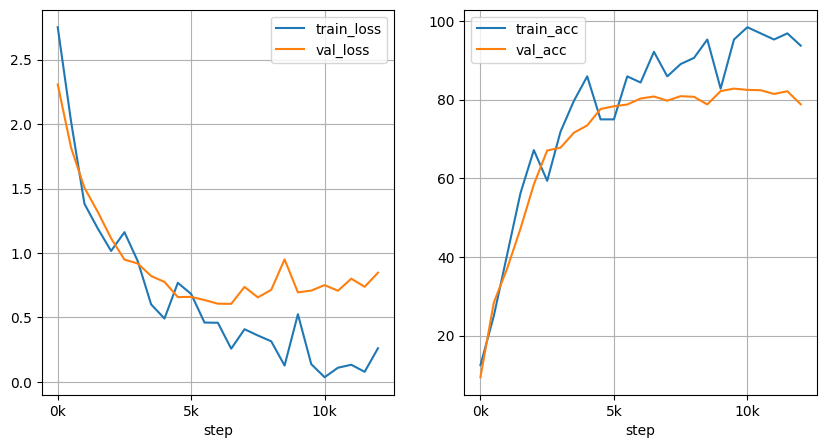

In [19]:
# 绘制损失曲线和准确率曲线
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [21]:
# 加载最佳模型权重
best_model = VGG11Network()
best_model.to(device)

# 从保存的权重文件中加载模型
model_path = os.path.join('model_weights', 'model_epoch_78.84_acc_17.0000.pth')

best_model.load_state_dict(torch.load(model_path))
print(f"成功加载模型权重: {model_path}")


# 在验证集上评估模型
val_accuracy, val_loss = evaluate_classification_model(best_model, val_loader, device, loss_fn)
print(f"验证集准确率: {val_accuracy:.2f}%")
print(f"验证集损失: {val_loss:.4f}")


成功加载模型权重: model_weights/model_epoch_78.84_acc_17.0000.pth
验证集准确率: 78.84%
验证集损失: 0.8474


成功加载预训练权重，排除了分类器的最后一层
开始微调预训练的VGG11模型...
训练开始，共14080步


  0%|          | 0/14080 [00:00<?, ?it/s]

早停触发!
84.8400
早停: 在13000 步


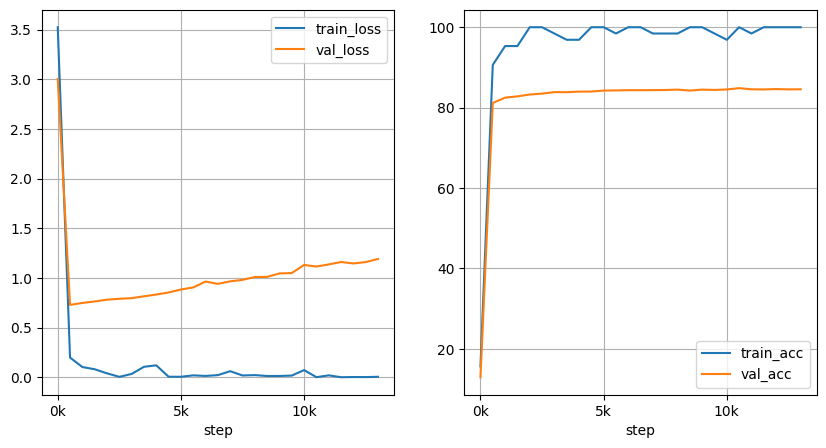

微调后模型在验证集上的准确率: 84.56%
微调后模型在验证集上的损失: 1.1904

性能比较:
原始模型验证集准确率: 78.84%
微调模型验证集准确率: 84.56%
准确率提升: 5.72%


In [22]:
# 定义一个函数来获取预训练的VGG11模型并设置不同层的学习率
def get_finetuned_model(num_classes=10):
    # 加载预训练的VGG11模型
    model = VGG11Network.from_pretrained(model_path)

    # 将模型移至设备
    model = model.to(device)

    # 为不同层设置不同的学习率
    # 冻结特征提取层参数或使用较小的学习率
    feature_params = []
    classifier_params = []

    # 将参数分为特征提取层和分类层
    for name, param in model.named_parameters():
        if 'classifier' in name:
            if '6' in name:  # 最后一层（新添加的分类层)
                classifier_params.append(param)
            else:  # 分类器的其他层
                feature_params.append(param)
        else:  # 特征提取层
            feature_params.append(param)

    # 创建优化器，对不同层使用不同的学习率
    optimizer = torch.optim.Adam([
        {'params': feature_params, 'lr': 1e-5},  # 特征提取层使用较小的学习率
        {'params': classifier_params, 'lr': 1e-3}  # 分类层使用较大的学习率
    ])

    return model, optimizer

# 获取微调模型和优化器
finetune_model, finetune_optimizer = get_finetuned_model()

# 训练微调模型
finetune_early_stopping = EarlyStopping(patience=5)
finetune_model_saver = ModelSaver(save_dir='finetune_model_weights', save_best_only=True)

print("开始微调预训练的VGG11模型...")
finetune_model, finetune_history = train_classification_model(
    finetune_model,
    train_loader,
    val_loader,
    loss_fn,
    finetune_optimizer,
    device,
    num_epochs=20,
    early_stopping=finetune_early_stopping,
    model_saver=finetune_model_saver
)

# 绘制微调模型的学习曲线
plot_learning_curves(finetune_history, sample_step=500)

# 评估微调后的模型
finetune_val_accuracy, finetune_val_loss = evaluate_classification_model(finetune_model, val_loader, device, loss_fn)
print(f"微调后模型在验证集上的准确率: {finetune_val_accuracy:.2f}%")
print(f"微调后模型在验证集上的损失: {finetune_val_loss:.4f}")

# 比较原始模型和微调模型的性能
print("\n性能比较:")
print(f"原始模型验证集准确率: {val_accuracy:.2f}%")
print(f"微调模型验证集准确率: {finetune_val_accuracy:.2f}%")
print(f"准确率提升: {finetune_val_accuracy - val_accuracy:.2f}%")


In [27]:
a =py7zr.SevenZipFile(r'./test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [28]:
!ls competitions/cifar-10/test|wc -l

300000


In [29]:
# 导入所需库
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm

# 定义测试数据集类
class CIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        初始化测试数据集

        参数:
            img_dir: 测试图片目录
            transform: 图像预处理变换
        """
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 提取图像ID（文件名去掉扩展名）
        img_id = int(os.path.splitext(self.img_files[idx])[0])

        return image, img_id

# 定义预测函数
def predict_test_set(model, img_dir, labels_file, device, batch_size=64):
    """
    预测测试集并生成提交文件

    参数:
        model: 训练好的模型
        img_dir: 测试图片目录
        labels_file: 提交模板文件路径
        device: 计算设备
        batch_size: 批处理大小
    """
    # 图像预处理变换（与训练集相同）
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
    ])

    # 创建测试数据集和数据加载器
    test_dataset = CIFAR10TestDataset(img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # 设置模型为评估模式
    model.eval()

    # 读取提交模板
    submission_df = pd.read_csv(labels_file)
    predictions = {}

    # 使用tqdm显示进度条
    print("正在预测测试集...")
    with torch.no_grad():
        for images, img_ids in tqdm.tqdm(test_loader, desc="预测进度"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #取最大的索引，作为预测结果

            # 记录每个图像的预测结果
            for i, img_id in enumerate(img_ids):
                predictions[img_id.item()] = predicted[i].item() #因为一个批次有多个图像，所以需要predicted[i]

    # 定义类别名称
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # 将数值标签转换为类别名称
    labeled_predictions = {img_id: class_names[pred] for img_id, pred in predictions.items()}

    # 直接创建DataFrame
    submission_df = pd.DataFrame({
        'id': list(labeled_predictions.keys()),
        'label': list(labeled_predictions.values())
    })
    # 按id列排序
    submission_df = submission_df.sort_values(by='id')

    # 检查id列是否有重复值
    has_duplicates = submission_df['id'].duplicated().any()
    print(f"id列是否有重复值: {has_duplicates}")
    # 保存预测结果
    output_file = 'cifar10_submission.csv'
    submission_df.to_csv(output_file, index=False)
    print(f"预测完成，结果已保存至 {output_file}")

# 执行测试集预测
img_dir = r"competitions/cifar-10/test"
labels_file = r"./sampleSubmission.csv"
predict_test_set(model, img_dir, labels_file, device, batch_size=128)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


正在预测测试集...


预测进度:   0%|          | 0/2344 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
预测进度: 100%|██████████| 2344/2344 [02:13<00:00, 17.50it/s]


id列是否有重复值: False
预测完成，结果已保存至 cifar10_submission.csv


In [30]:
!head -10 cifar10_submission.csv

id,label
1,airplane
2,airplane
3,automobile
4,ship
5,airplane
6,cat
7,airplane
8,bird
9,dog
